## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

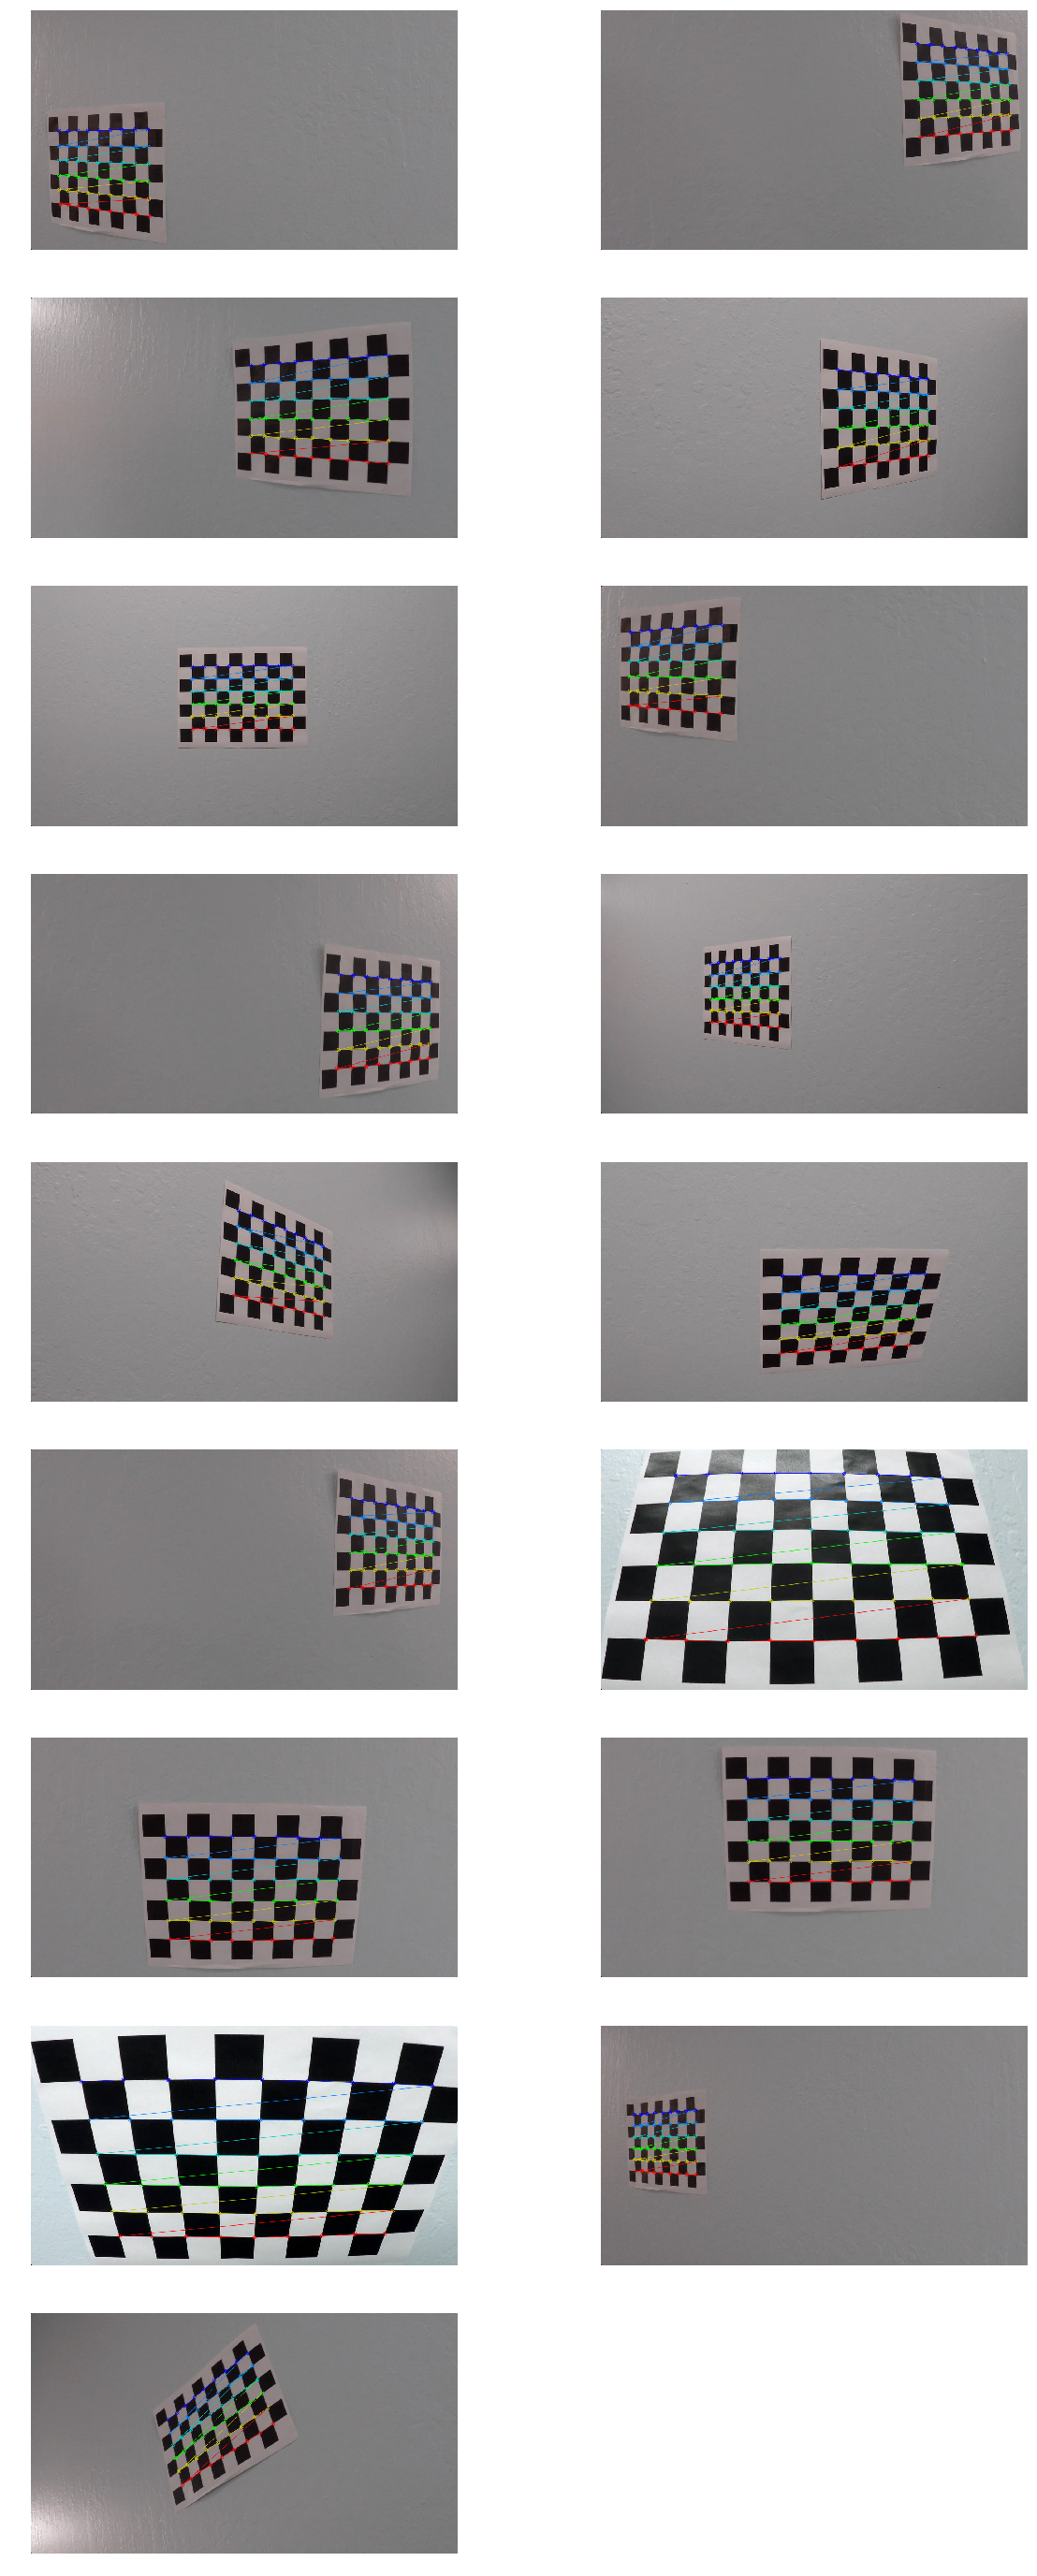

In [1]:
import os
import math
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

%matplotlib inline


def show_images(images, ncol=2, titles=None, cmap=None):
    nrow = math.ceil(len(images) / ncol)
    gs1 = gridspec.GridSpec(nrow, ncol)
    gs1.update(wspace=0.1, hspace=0.1) # set the spacing between axes. 
    plt.figure(figsize=(20, 50))

    for i in range(len(images)):
        ax1 = plt.subplot(gs1[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')

        plt.subplot(nrow, ncol, i+1)
        if titles:
            plt.title(titles[i])
        plt.imshow(images[i], cmap=cmap)
        plt.axis('off')

    plt.show()


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
corner_images = []
all_images = []

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    all_images.append(img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        corner_img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        corner_images.append(corner_img)
        
        img_name = os.path.split(fname)[1]
        output_name = os.path.join('output_images', 'corner_' + img_name)
        cv2.imwrite(output_name, corner_img)
        

show_images(corner_images)


## Apply a distortion correction to raw images.

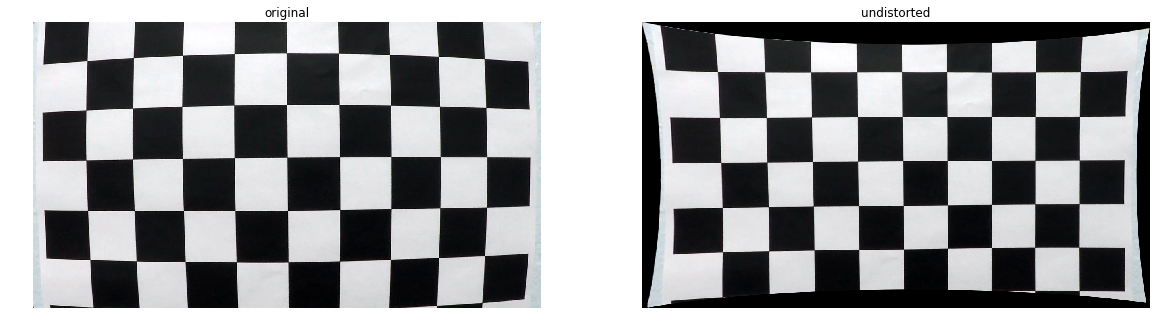

In [2]:


def cal_undistort(img, objpoints, imgpoints):
    h,  w = img.shape[:2]
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (h, w), None, None)
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
    undist = cv2.undistort(img, mtx, dist, None, newcameramtx)
    return undist

distorted = cv2.imread('camera_cal/calibration1.jpg')
new_img = cal_undistort(distorted, objpoints, imgpoints)
show_images([distorted, new_img], titles=['original', 'undistorted'])


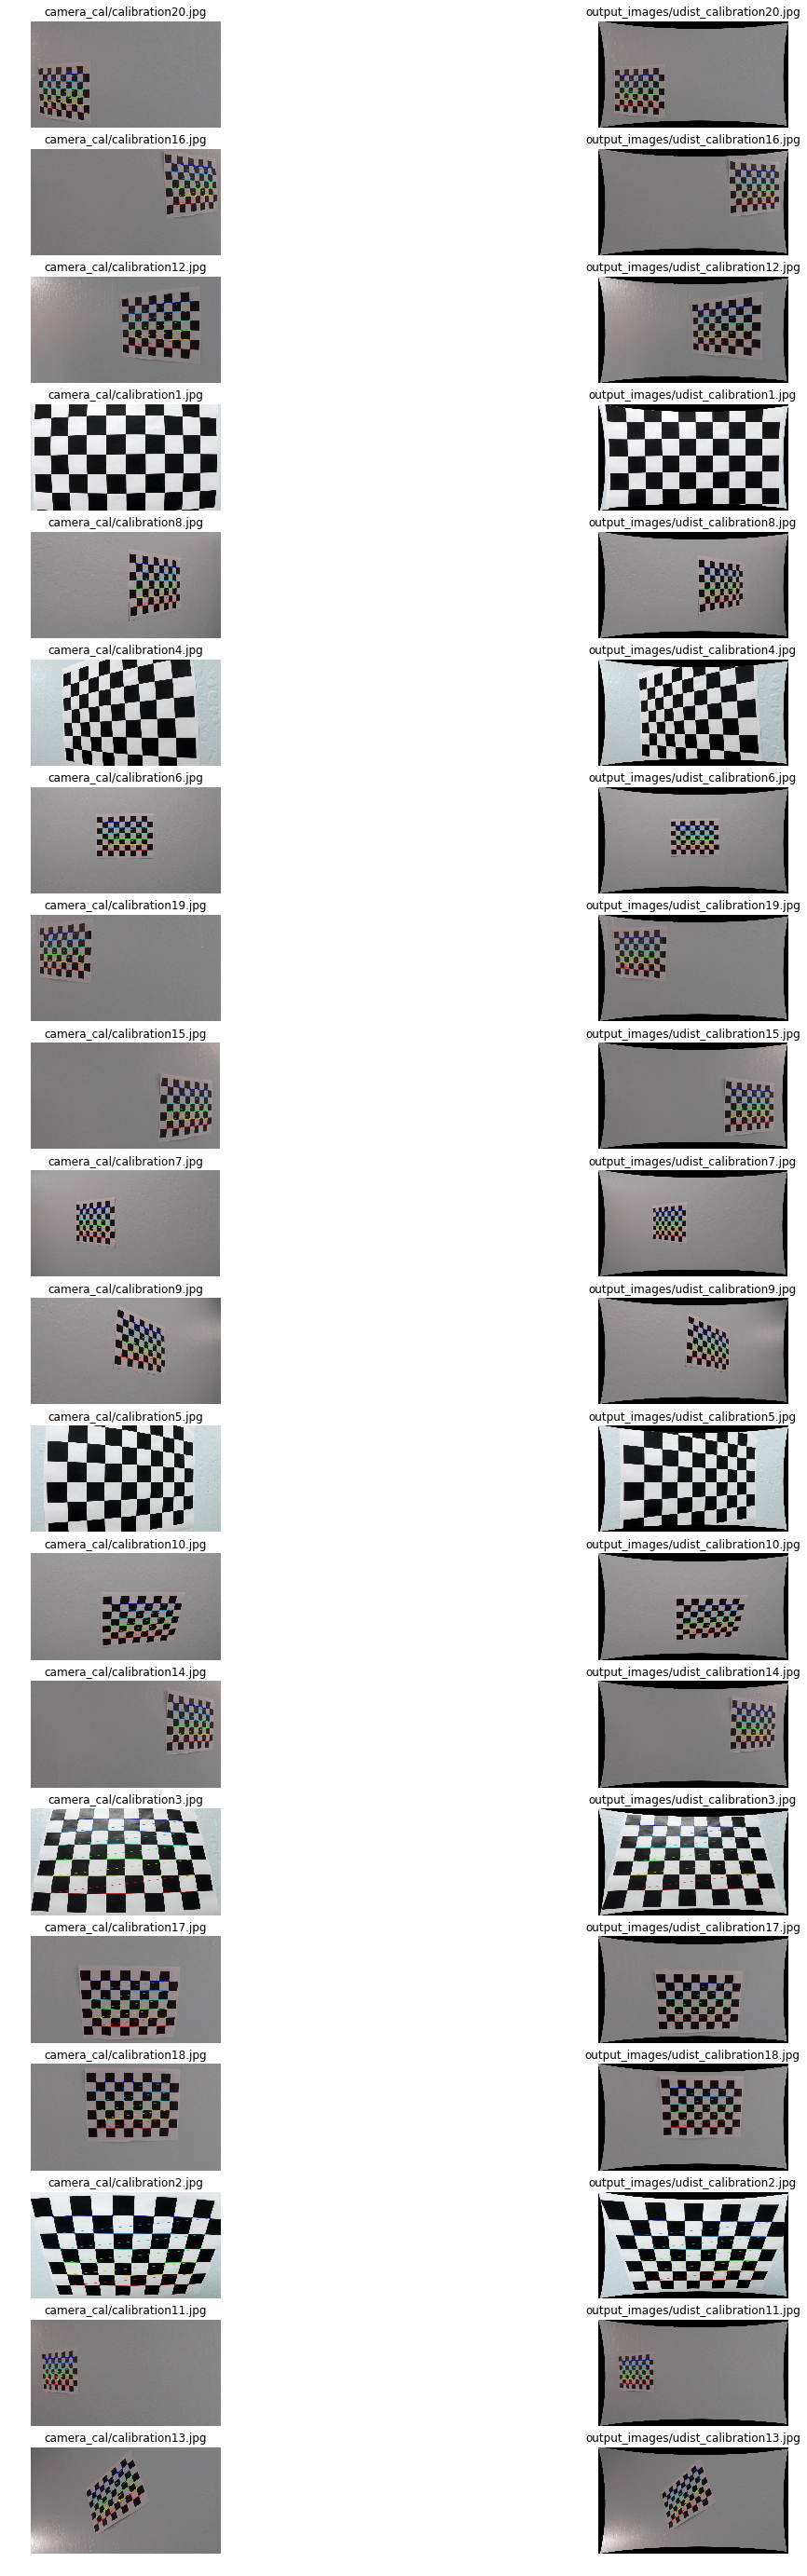

In [3]:
undistored_images = []
to_show = []
to_show_titles = []
for i, fname in enumerate(images):
    img_name = os.path.split(fname)[1]
    output_name = os.path.join('output_images', 'udist_' + img_name)
    img = all_images[i]
    undistorted = cal_undistort(img, objpoints, imgpoints)
    cv2.imwrite(output_name, undistorted)
    to_show.extend([img, undistorted])
    to_show_titles.extend([fname, output_name])
show_images(to_show, titles=to_show_titles)


## Use color transforms, gradients, etc., to create a thresholded binary image.

In [4]:
def to_binary(img, s_thresh=None, sx_thresh=None):
    if s_thresh is None:
        s_thresh = (170, 255)
    if sx_thresh is None:
        sx_thresh = (20, 100)
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]

    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    combined_binary = 255*np.dstack((combined_binary, combined_binary, combined_binary)).astype('uint8') 
    return color_binary, combined_binary    

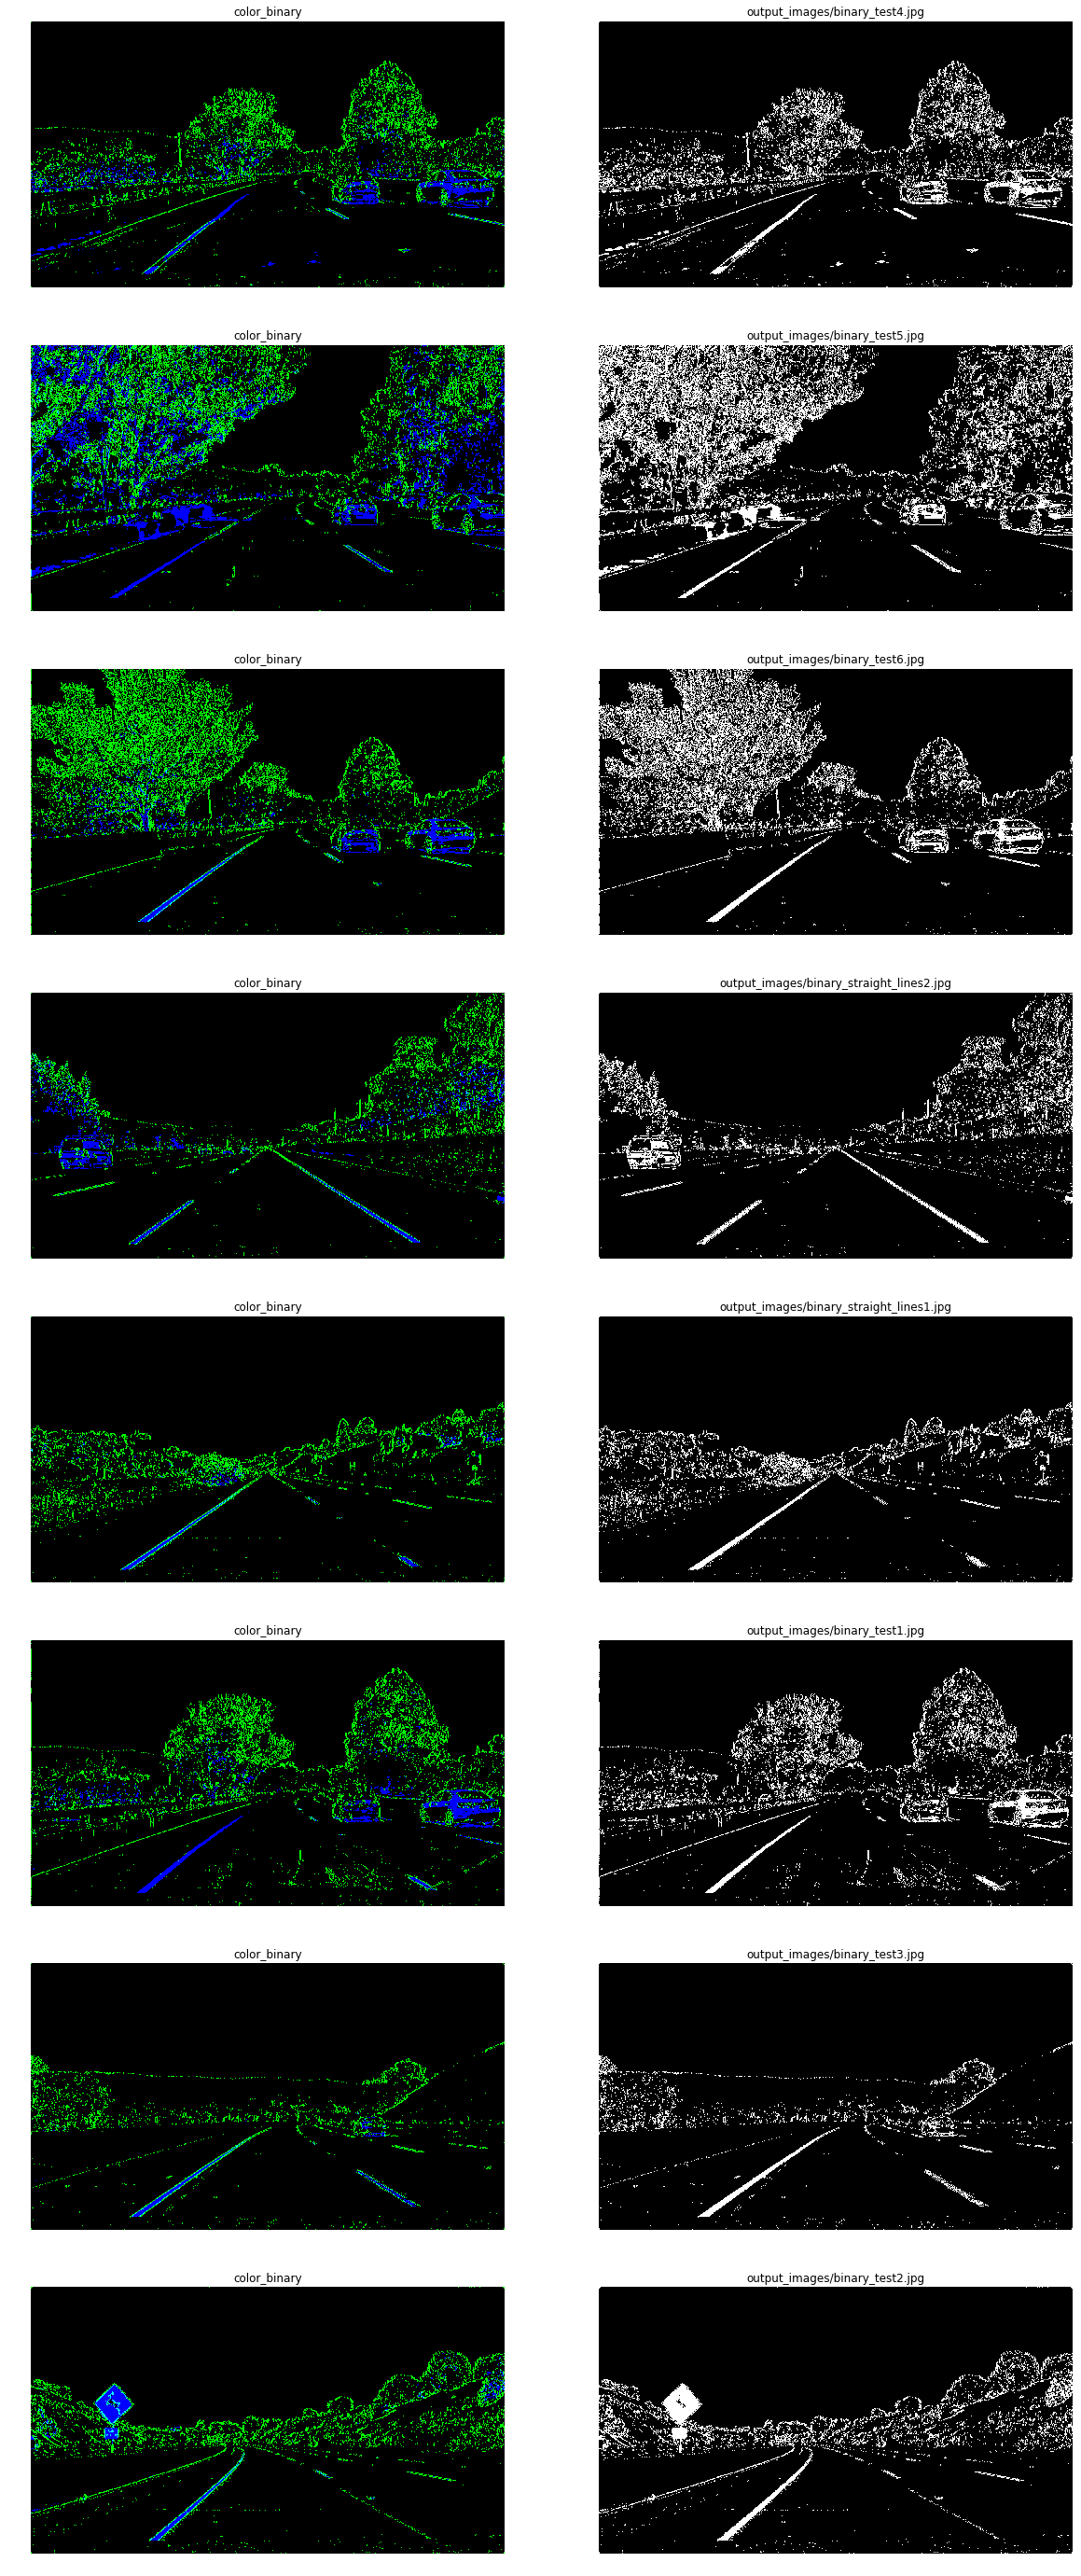

In [5]:
test_images = glob.glob('test_images/*.jpg')
plt_binary_images = []
titles = []
for fname in test_images:
    img = cv2.imread(fname)
    color_binary, binary_img = to_binary(img)
    plt_binary_images.extend([color_binary, binary_img])
    img_name = os.path.split(fname)[1]
    output_name = os.path.join('output_images', 'binary_' + img_name)
    cv2.imwrite(output_name, binary_img)
    titles.extend(['color_binary', output_name])
show_images(plt_binary_images, titles=titles)

## Apply a perspective transform to rectify binary image ("birds-eye view").

In [8]:
def get_vertices(xsize, ysize):
    lower_left = (xsize * 1/15, ysize)
    lower_right = (xsize * 19/20, ysize)
    upper_left = (xsize * 3/7, ysize * 3/5)
    upper_right = (xsize * 4/7, ysize * 3/5)
    lower_left = (0, ysize)
    lower_right =(xsize, ysize)
    upper_left = (0, 0)
    upper_right = (xsize, 0)
    return np.array([[upper_left, lower_left, 
                      lower_right, upper_right]], 
                    dtype=np.int32)


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    # cv2.fillPoly(mask, vertices, ignore_mask_color)
    cv2.fillPoly(mask, vertices, (0, 255, 0))
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def warp(img):
    img_size = (img.shape[1], img.shape[0])

    # LR, LF, RF, RR
    src = np.float32([
        [342, 627],
        [603, 453],
        [708, 453],
        [990, 627],
    ])

    dst = np.float32([
        [200, 710],
        [200, 0],
        [1080, 0],
        [1080, 710],
    ])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)
    return warped, M, Minv    

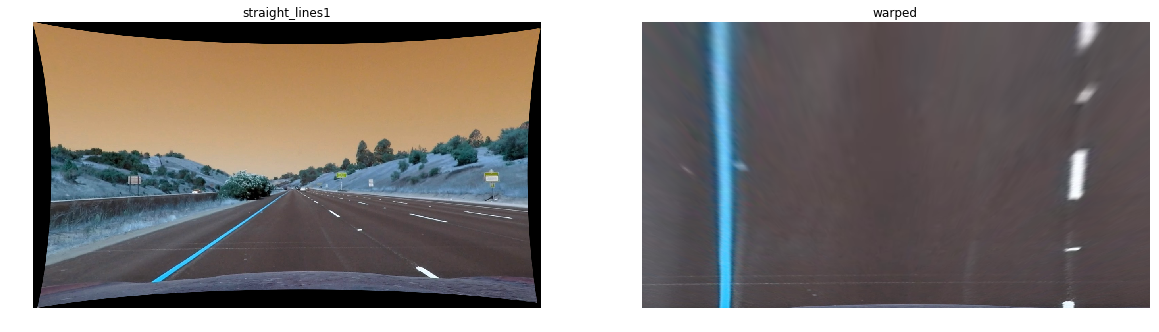

True

In [9]:
img = cv2.imread('test_images/straight_lines1.jpg')
undist_img = cal_undistort(img, objpoints, imgpoints)
# cv2.imwrite('/tmp/undist.jpg', undist_img)
warped_img, _, _ = warp(undist_img)

show_images([undist_img, warped_img], titles=['straight_lines1', 'warped'])
cv2.imwrite('output_images/warped_straight_lines1.jpg', warped_img)

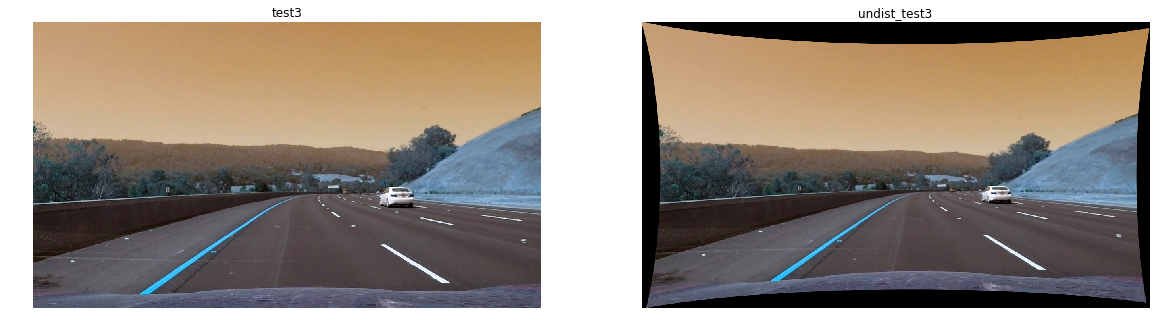

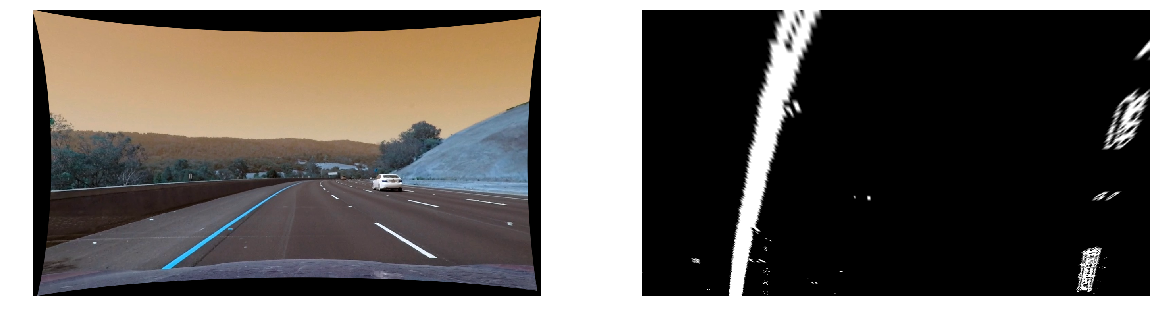

In [10]:
def warp_binary(img):
    undist_img = cal_undistort(img, objpoints, imgpoints)
    _, binary_img = to_binary(undist_img)
    warped_img, M, Minv = warp(binary_img)
    return warped_img, M, Minv
    # ysize, xsize = img.shape[:2]
    # img = region_of_interest(warped_img, get_vertices(xsize, ysize))
    # return img
    
warped_binary_img, _, Minv = warp_binary(img)

test_img3 = cv2.imread('test_images/test3.jpg')
undist_test_img3 = cal_undistort(test_img3, objpoints, imgpoints)
warped_binary_img3, _, Minv = warp_binary(test_img3)

show_images([test_img3, undist_test_img3], titles=['test3', 'undist_test3'])
show_images([undist_test_img3,  warped_binary_img3], cmap='gray')

(53574,)
(720,)


(720, 0)

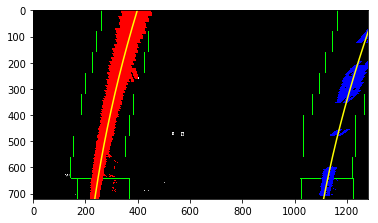

In [11]:
binary_warped =  cv2.cvtColor(warped_binary_img3, cv2.COLOR_BGR2GRAY)

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

print(leftx.shape)
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ysize, xsize = binary_warped.shape[:2]
ploty = np.linspace(0, ysize - 1, ysize)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

print(left_fitx.shape)
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [12]:

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)

print(ploty.shape, leftx.shape)
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

(720,) (53574,)
1530.61465128 m 1418.23913941 m


## Warp the detected lane boundaries back onto the original image.

True

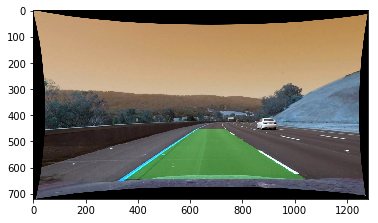

In [13]:
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
newwarp = cv2.warpPerspective(color_warp, Minv, (xsize, ysize)) 
result = cv2.addWeighted(undist_test_img3, 1, newwarp, 0.3, 0)

x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
plt.imshow(result)
cv2.imwrite('output_images/overlay_test3.jpg', result)

In [15]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


def find_fit(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit


def map_lane(undist_img, binary_warped, left_fitx, right_fitx):
    ysize, xsize = binary_warped.shape[:2]
    ploty = np.linspace(0, ysize - 1, ysize)
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (xsize, ysize)) 
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)

    x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
    x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
    return result


def process_image(img):
    warped_binary_img, _, Minv = warp_binary(img)
    undist_img = cal_undistort(img, objpoints, imgpoints)
    binary_warped =  cv2.cvtColor(warped_binary_img, cv2.COLOR_BGR2GRAY)
    left_fit, right_fit = find_fit(binary_warped)
    # Generate x and y values for plotting
    ysize, xsize = binary_warped.shape[:2]
    ploty = np.linspace(0, ysize-1, ysize )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    result = map_lane(undist_img, binary_warped, left_fitx, right_fitx)
    return result
    
clip1 = VideoFileClip('project_video.mp4')
output = 'project_video_out.mp4'
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [56:49<00:02,  3.00s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 57min 43s, sys: 4.01 s, total: 57min 47s
Wall time: 56min 50s
